In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
base_path = "data"
train = pd.read_csv(f'{base_path}/train.csv.zip', index_col="ID")
test = pd.read_csv(f'{base_path}/test.csv.zip', index_col="ID")
submission = pd.read_csv(f'{base_path}/sample_submission.csv.zip', index_col="ID")

In [3]:
cat_col = train.select_dtypes(include="object").columns
train[cat_col] = train[cat_col].astype("category")
test[cat_col] = test[cat_col].astype("category")

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4209 entries, 0 to 8417
Columns: 377 entries, y to X385
dtypes: category(8), float64(1), int64(368)
memory usage: 11.9 MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4209 entries, 1 to 8416
Columns: 376 entries, X0 to X385
dtypes: category(8), int64(368)
memory usage: 11.9 MB


In [6]:
import lightgbm 
model_lgbmr = lightgbm.LGBMRegressor(boosting_type='goss', 
                                    n_estimators=1000, max_depth=3,
                                    metrics=["mae", "mse"],
                                    n_jobs=-1,
                                    learning_rate=0.01, random_state=42)
model_lgbmr

LGBMRegressor(boosting_type='goss', learning_rate=0.01, max_depth=3,
              metrics=['mae', 'mse'], n_estimators=1000, random_state=42)

In [7]:
# 데이터를 전처리하지 않고 category 형태로 넣어주면 알아서 학습합니다.
# category형태로 되어 있다면 인코딩 과정이 필요 없습니다.
from sklearn.model_selection import cross_val_score

y_val_score = cross_val_score(model_lgbmr, 
                                  train.drop(columns="y"), 
                                  train["y"], cv=3)
lgbmr_score = y_val_score.mean()
lgbmr_score

0.5402454232905368

In [8]:
# fit & predict
# y_pred_lgbmr
model_lgbmr.fit(train.drop(columns="y"), train["y"])

LGBMRegressor(boosting_type='goss', learning_rate=0.01, max_depth=3,
              metrics=['mae', 'mse'], n_estimators=1000, random_state=42)

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.plot_importance.html

LightGBM에서는 XGBoost와 달리, Leaf-wise 트리 생성 방법을 사용하므로, feature importance를 계산하는 방법도 조금 다릅니다. 

각 feature가 어떤 트리에서 어느 위치에서 사용되었는지에 따라, 해당 feature에 대한 Split Gain을 계산합니다. Split Gain은 해당 feature를 사용하여 데이터를 분할했을 때 감소하는 평균 제곱 오차(MSE)를 나타내는 지표입니다.
모든 트리에서 계산된 Split Gain을 누적하여, 해당 feature의 importance를 계산합니다.

LightGBM의 plot_importance 함수에서는 importance_type 인수를 설정하여 feature importance를 구하는 방법을 선택할 수 있습니다. importance_type 인수에는 다음과 같은 값을 지정할 수 있습니다.

* split: 각 feature가 분할을 위해 사용된 빈도수
* gain: 각 feature가 분할을 했을 때 트리의 평균 손실(MSE) 감소량
* total_gain: 모든 트리에서 각 feature가 분할을 했을 때 트리의 평균 손실(MSE) 감소량의 합
* weight: 각 feature가 분할된 리프 노드에서 해당 feature의 데이터 건수
* total_cover: 모든 트리에서 각 feature가 분할된 리프 노드에서 해당 feature의 데이터 건수의 합

<Axes: >

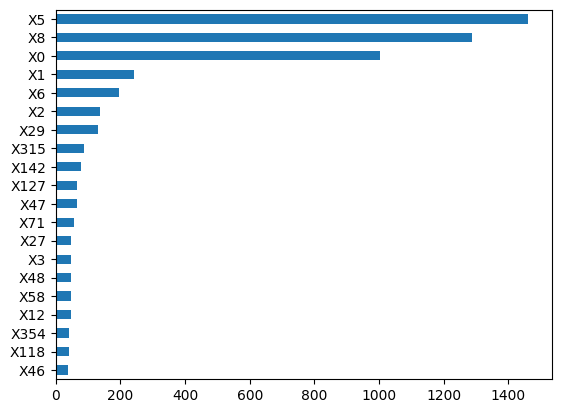

In [9]:
fi = pd.Series(model_lgbmr.feature_importances_)
fi.index = model_lgbmr.feature_name_
fi.nlargest(20).sort_values().plot.barh()

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

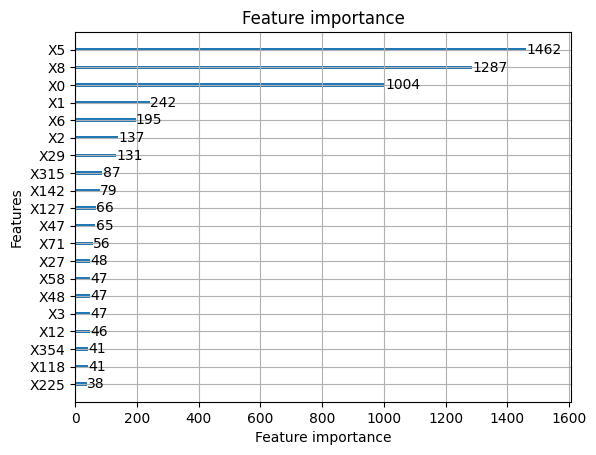

In [10]:
# lgbm.plot_importance(model_lgbm)
lightgbm.plot_importance(model_lgbmr, max_num_features=20)

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.plot_tree.html#lightgbm.plot_tree

show_info (list of str, or None, optional (default=None)) –

What information should be shown in nodes.

'split_gain' : gain from adding this split to the model

'internal_value' : raw predicted value that would be produced by this node if it was a leaf node

'internal_count' : number of records from the training data that fall into this non-leaf node

'internal_weight' : total weight of all nodes that fall into this non-leaf node

'leaf_count' : number of records from the training data that fall into this leaf node

'leaf_weight' : total weight (sum of Hessian) of all observations that fall into this leaf node

'data_percentage' : percentage of training data that fall into this node

<Axes: >

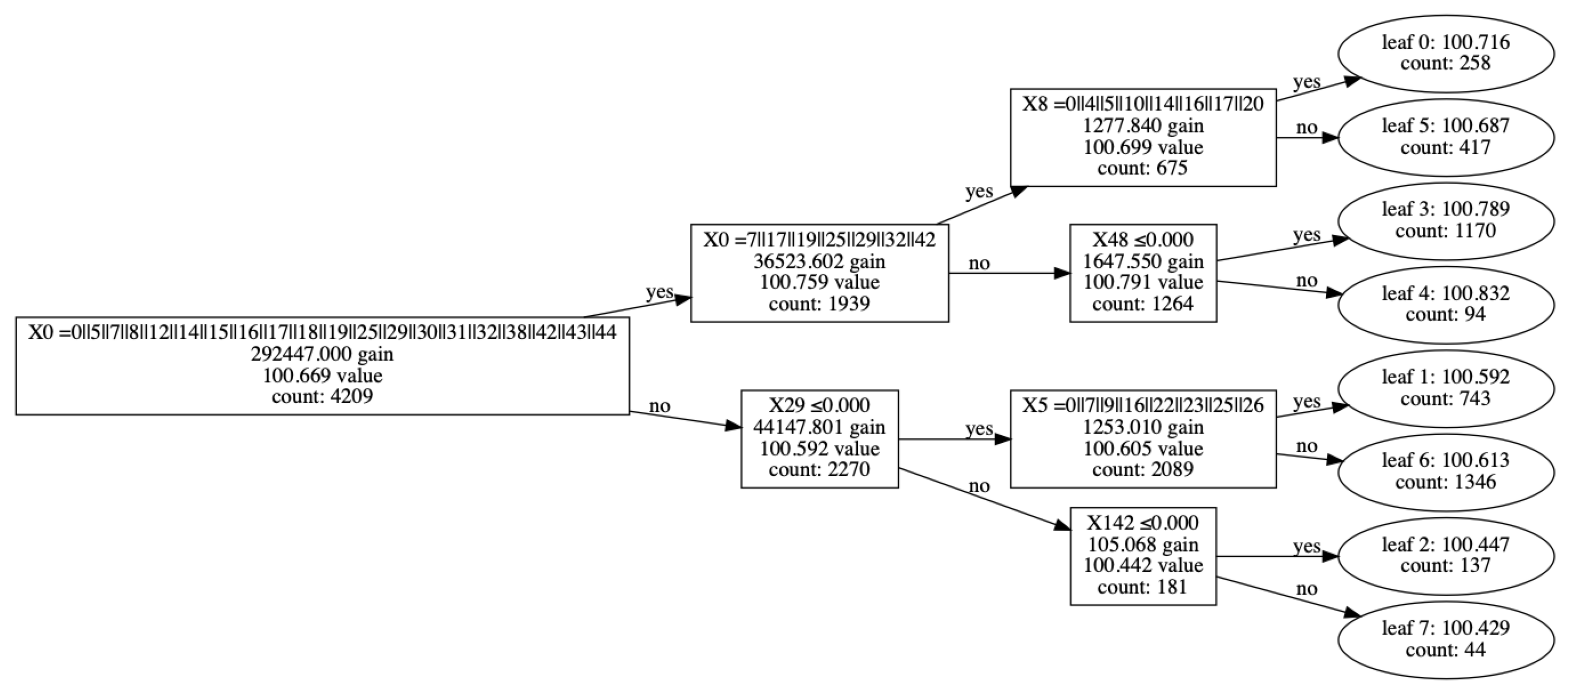

In [11]:
lightgbm.plot_tree(model_lgbmr, figsize=(20, 20), tree_index=0,
                   show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count']
                   )

In [12]:
y_pred_lgbmr = model_lgbmr.predict(test)
y_pred_lgbmr[:5]

array([ 77.38155957,  93.44779391,  79.72941463,  78.34595373,
       113.04531805])

In [13]:
submission["y"] = y_pred_lgbmr

In [14]:
file_name = f"submit_lgbmr_category_{lgbmr_score:.5f}.csv"
file_name

'submit_lgbmr_category_0.54025.csv'

In [15]:
submission.to_csv(file_name)
pd.read_csv(file_name).head(2)

,ID,y
0,1,77.381560
1,2,93.447794
